<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 10.3 PySpark for Big Data

## Introduction

**Note**: this notebook is to be run in Google Colab on your Google Drive. It will not work locally on your computer.

The purpose of this lab is to gain further exposure to cloud computing, often necessary when datasets become too large to manage on a local machine. You will learn how to work with a large dataset through the PySpark Python library with Google Colaboratory (Colab).

In Google Colab, a virtual machine is automatically set up to execute your code. The maximum lifetime of such a machine is 12 hours. Note that notebooks will be disconnected from virtual machines if left idle. If this happens simple click on the Connect button to reconnect. If the kernel needs to be restarted (via the Runtime menu), variables may be lost but packages would not need to be reinstalled unless a new machine is assigned.

https://research.google.com/colaboratory/faq.html

Sign into colab.research.google.com and choose the Upload tab and upload this notebook.  This will automatically create a folder called "Colab Notebooks" in your Google Drive (if it does not already exist).

Apache Spark is an open-source cluster-computing framework, able to work with large datasets quickly by performing in-memory caching and computation. Pyspark is a Python API for Spark commonly used to manipulate big data. For reference one useful cheat sheet is available at https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_SQL_Cheat_Sheet_Python.pdf


Fortunately Pyspark is straightforward to setup in Google Colab:

In [16]:
!pip install pyspark py4j

To work with Spark DataFrames we firstly need to create a Spark DataFrame:

In [17]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, trim, avg, round, when
from pyspark import SparkFiles

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
spark = SparkSession.builder.appName("populationdata").getOrCreate()

In [19]:
spark

## Loading the dataset and EDA

The dataset to be analyzed in this lab shows population estimates by age and gender:

   - PopMale: Male population for the individual age (thousands)
   - PopFemale: Female population for the individual age (thousands)
   - PopTotal: Total population for the individual age (thousands)

Further details can be found at https://population.un.org/wpp/.

In [20]:
from google.colab import drive

In [21]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# run this cell after uploading the file into your Colab Notebooks folder
df = spark.read.csv(r"/content/drive/MyDrive/Colab Notebooks/WPP2019_PopulationBySingleAgeSex_1950-2019.csv", header=True)

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
type(df)

pyspark.sql.dataframe.DataFrame

In [25]:
df

DataFrame[LocID: string, Location: string, VarID: string, Variant: string, Time: string, MidPeriod: string, AgeGrp: string, AgeGrpStart: string, AgeGrpSpan: string, PopMale: string, PopFemale: string, PopTotal: string]

Note that unlike Pandas this does not display a preview of the dataset, only the schema. This is because Spark performs lazy evaluation, only displaying rows when needed.

In [26]:
df.columns

['LocID',
 'Location',
 'VarID',
 'Variant',
 'Time',
 'MidPeriod',
 'AgeGrp',
 'AgeGrpStart',
 'AgeGrpSpan',
 'PopMale',
 'PopFemale',
 'PopTotal']

**Exercise**: How many rows does df contain?

In [27]:
# ANSWER
df.count()

1594558

In [28]:
df.rdd.getNumPartitions()

2

This corresponds to the number of cores in a free Google Colab instance.

In [29]:
df.printSchema()

root
 |-- LocID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- VarID: string (nullable = true)
 |-- Variant: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- MidPeriod: string (nullable = true)
 |-- AgeGrp: string (nullable = true)
 |-- AgeGrpStart: string (nullable = true)
 |-- AgeGrpSpan: string (nullable = true)
 |-- PopMale: string (nullable = true)
 |-- PopFemale: string (nullable = true)
 |-- PopTotal: string (nullable = true)



We use df.show() similarly to df.head() in Pandas.

In [30]:
df.show()

+-----+-----------+-----+-------+----+---------+------+-----------+----------+-------+---------+--------+
|LocID|   Location|VarID|Variant|Time|MidPeriod|AgeGrp|AgeGrpStart|AgeGrpSpan|PopMale|PopFemale|PopTotal|
+-----+-----------+-----+-------+----+---------+------+-----------+----------+-------+---------+--------+
|    4|Afghanistan|    2| Medium|1950|   1950.5|     0|          0|         1|139.669|  154.913| 294.582|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     1|          1|         1|131.916|  141.851| 273.767|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     2|          2|         1|125.127|  130.632| 255.759|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     3|          3|         1| 119.22|  121.097| 240.317|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     4|          4|         1|114.112|  113.085| 227.197|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     5|          5|         1|109.723|  106.436| 216.159|
|    4|Afghanistan|    2| Medium|1950|   1950.

In [31]:
df.describe()

DataFrame[summary: string, LocID: string, Location: string, VarID: string, Variant: string, Time: string, MidPeriod: string, AgeGrp: string, AgeGrpStart: string, AgeGrpSpan: string, PopMale: string, PopFemale: string, PopTotal: string]

Once again evaluation of describe is lazy, we use show() to display results:

In [ ]:
df.describe().show()

+-------+------------------+--------------------+-------+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|summary|             LocID|            Location|  VarID|Variant|              Time|         MidPeriod|            AgeGrp|       AgeGrpStart|        AgeGrpSpan|          PopMale|         PopFemale|          PopTotal|
+-------+------------------+--------------------+-------+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+
|  count|           1594558|             1594558|1594557|1594557|           1594557|           1594557|           1594557|           1594557|           1594557|          1594557|           1594557|           1594557|
|   mean|1033.3049070651552|                NULL|    2.0|   NULL|1984.4614403875182|1984.9614403875182|49.999319560228955|49.9993195

Let us remove rows we do not need.

In [ ]:
df.select('VarID', 'Variant').distinct().show()

+-----+-------+
|VarID|Variant|
+-----+-------+
|    2| Medium|
| NULL|   NULL|
+-----+-------+



As we will not work with other variant, we can safely drop these columns.

In [ ]:
df = df.drop('VarID', 'Variant')

In [32]:
df.show()

+-----+-----------+-----+-------+----+---------+------+-----------+----------+-------+---------+--------+
|LocID|   Location|VarID|Variant|Time|MidPeriod|AgeGrp|AgeGrpStart|AgeGrpSpan|PopMale|PopFemale|PopTotal|
+-----+-----------+-----+-------+----+---------+------+-----------+----------+-------+---------+--------+
|    4|Afghanistan|    2| Medium|1950|   1950.5|     0|          0|         1|139.669|  154.913| 294.582|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     1|          1|         1|131.916|  141.851| 273.767|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     2|          2|         1|125.127|  130.632| 255.759|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     3|          3|         1| 119.22|  121.097| 240.317|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     4|          4|         1|114.112|  113.085| 227.197|
|    4|Afghanistan|    2| Medium|1950|   1950.5|     5|          5|         1|109.723|  106.436| 216.159|
|    4|Afghanistan|    2| Medium|1950|   1950.

In [ ]:
df.select('Location').distinct().count()

225

In [ ]:
df.select('Location').distinct().show()

+--------------------+
|            Location|
+--------------------+
|       Côte d'Ivoire|
|                Chad|
|          Cabo Verde|
|       ECE: UNECE-52|
|ESCAP: ADB Develo...|
|ECLAC: The Caribbean|
|            Djibouti|
|African, Caribbea...|
|             Comoros|
|         Afghanistan|
|Belt-Road Initiat...|
|            Cambodia|
|Commonwealth of I...|
|       African Group|
|Countries with Ac...|
|Countries with Ac...|
|Central European ...|
|              Africa|
|African Union: We...|
|Countries with Ac...|
+--------------------+
only showing top 20 rows



**Exercise**: Repeat the above query, this time ordering the results by Location and using the truncate=False option to display results in full. Show all 440 results.

In [40]:
from os import truncate
# ANSWER
df.select('Location').distinct().orderBy('Location').show(440,truncate=False)

+-----------------------------------------------------------------+
|Location                                                         |
+-----------------------------------------------------------------+
|Afghanistan                                                      |
|Africa                                                           |
|African Group                                                    |
|African Union                                                    |
|African Union: Central Africa                                    |
|African Union: Eastern Africa                                    |
|African Union: Northern Africa                                   |
|African Union: Southern Africa                                   |
|African Union: Western Africa                                    |
|African, Caribbean and Pacific (ACP) Group of States             |
|Albania                                                          |
|Algeria                                        

Next run the following to confirm that there are no missing values in this dataset:

In [39]:
df.count() - df.na.drop().count()

1

## Convert types

We saw above that all columns are in the form of strings. The following cell converts some of the columns to type float.

In [38]:
floatcols = ['MidPeriod', 'PopMale', 'PopFemale', 'PopTotal']

for col_name in floatcols:
    df = df.withColumn(col_name, trim(col(col_name)).cast('float'))

**Exercise**: Similarly convert the four columns listed below into **integers**.

In [37]:
intcols = ['Time', 'AgeGrp', 'AgeGrpStart', 'AgeGrpSpan']

#ANSWER
for col_name in intcols:
    df = df.withColumn(col_name, trim(col(col_name)).cast('int'))

In [ ]:
df.printSchema()

root
 |-- LocID: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- VarID: string (nullable = true)
 |-- Variant: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- MidPeriod: float (nullable = true)
 |-- AgeGrp: integer (nullable = true)
 |-- AgeGrpStart: integer (nullable = true)
 |-- AgeGrpSpan: integer (nullable = true)
 |-- PopMale: float (nullable = true)
 |-- PopFemale: float (nullable = true)
 |-- PopTotal: float (nullable = true)



## Answering some queries about the data

We use filter to select a subset of rows satisfying a True/False condition:

Example: What was the population breakdown by age and gender in Australia in 1970?

In [36]:
df.filter((df.Location == 'Australia') & (df.Time == 1970)).show(101)

+-----+---------+-----+-------+----+---------+------+-----------+----------+-------+---------+--------+
|LocID| Location|VarID|Variant|Time|MidPeriod|AgeGrp|AgeGrpStart|AgeGrpSpan|PopMale|PopFemale|PopTotal|
+-----+---------+-----+-------+----+---------+------+-----------+----------+-------+---------+--------+
|   36|Australia|    2| Medium|1970|   1970.5|     0|          0|         1|126.482|   121.47| 247.952|
|   36|Australia|    2| Medium|1970|   1970.5|     1|          1|         1|126.326|  120.997| 247.323|
|   36|Australia|    2| Medium|1970|   1970.5|     2|          2|         1|126.439|  120.829| 247.268|
|   36|Australia|    2| Medium|1970|   1970.5|     3|          3|         1|126.751|  120.899|  247.65|
|   36|Australia|    2| Medium|1970|   1970.5|     4|          4|         1|127.193|   121.14| 248.333|
|   36|Australia|    2| Medium|1970|   1970.5|     5|          5|         1|127.698|  121.488| 249.186|
|   36|Australia|    2| Medium|1970|   1970.5|     6|          6

The select function can select a subset of columns.

**Exercise**: What was the population of 45-year-old females in India in 1960?

In [35]:

df.filter((df.Location == 'India') & (df.Time == 1960) & (df.AgeGrp == 45)).select('PopFemale').show()

+---------+
|PopFemale|
+---------+
| 1987.196|
+---------+



**Exercise**: Write a filter query to show the distinct locations starting with 'UN'.

In [13]:
# ANSWER


+--------+
|location|
+--------+
+--------+



Another example: what is the population of each location in 1950 and 2019?

In [41]:
populations_in_1950 = df.filter(df.Time == 1950)\
                    .groupBy('Location')\
                    .sum('PopTotal')\
                    .withColumnRenamed('sum(PopTotal)', 'Population_1950')\
                    .withColumn('Population_1950', round('Population_1950', 3))\
                    .orderBy(col('Population_1950').desc())
populations_in_1950.show()

+--------------------+---------------+
|            Location|Population_1950|
+--------------------+---------------+
|Countries with Ac...|    2384540.117|
|Group of Twenty (...|    1731945.275|
|   Group of 77 (G77)|    1618241.347|
|ESCAP: income groups|    1490837.911|
|   ESCAP: HDI groups|    1490837.911|
|ESCAP: WB income ...|    1490818.181|
|                Asia|    1404908.989|
|  Asia-Pacific Group|    1397562.214|
|Countries with Ac...|     1364302.65|
|ESCAP: ADB Develo...|    1223407.377|
|Asia-Pacific Econ...|    1136577.758|
|               BRICS|    1101146.274|
|              Europe|    1098657.721|
|                BRIC|    1087517.847|
|Belt-Road Initiat...|     934148.834|
|Eastern and South...|     842669.337|
|       ECE: UNECE-52|     770020.389|
|ESCAP: WB Upper m...|     737341.529|
|Europe and Northe...|      721931.47|
|ESCAP: ADB Group ...|     718170.833|
+--------------------+---------------+
only showing top 20 rows



In [43]:
populations_in_2019 = df.filter(df.Time == 2019)\
                    .groupBy('Location')\
                    .sum('PopTotal')\
                    .withColumnRenamed('sum(PopTotal)', 'Population_2019')\
                    .withColumn('Population_2019', round('Population_2019', 3))\
                    .orderBy(col('Population_2019').desc())


In [44]:
populations_in_1950.join(populations_in_2019, 'Location').orderBy('Location').show()

+--------------------+---------------+---------------+
|            Location|Population_1950|Population_2019|
+--------------------+---------------+---------------+
|         Afghanistan|       7752.117|      38041.757|
|              Africa|     227794.137|    1308064.174|
|       African Group|     227511.873|    1306320.571|
|       African Union|     227525.637|    1306903.022|
|African Union: Ce...|      24214.661|     154013.705|
|African Union: Ea...|      55336.034|     382531.218|
|African Union: No...|      43705.252|     203493.227|
|African Union: So...|      34051.198|     179956.492|
|African Union: We...|       70218.49|     386908.388|
|African, Caribbea...|     199979.667|    1150190.577|
|             Albania|       1263.164|       2880.913|
|             Algeria|        8872.25|      43053.054|
|    Andean Community|      26311.024|     111736.664|
|              Angola|       4548.021|      31825.299|
| Antigua and Barbuda|         45.515|         97.115|
|         

**Exercise**: Which locations had the largest percentage change in population from 1950 to 2019?

In [46]:
# ANSWER
df.filter(populations_in_1950.join & populations_in_2019), ('Location').orderBy('Location').show()

TypeError: unsupported operand type(s) for &: 'method' and 'DataFrame'

**Bonus Exercise**: In 2019 which locations have the highest percentage of seniors (age 80+) relative to their total population?

(Hint: if you find Japan, Greece and Italy you are right!)

In [ ]:
# ANSWER


## Population line plot

In this section, we use a query to perform a data visualization with matplotlib. We shall plot population vs year for three countries.

In [ ]:
df_3countries = df[df.Location.isin("Australia", "New Zealand", "Singapore")]\
                  .select('Location', 'MidPeriod', 'PopTotal') \
                  .groupBy('Location', 'MidPeriod')\
                  .sum('PopTotal')\
                  .withColumnRenamed('sum(PopTotal)', 'Population')\
                  .withColumn('Population', round('Population', 3))
df_3countries.show()

+---------+---------+----------+
| Location|MidPeriod|Population|
+---------+---------+----------+
|Australia|   1970.5|  12793.03|
|Australia|   2001.5| 19194.676|
|Australia|   2013.5| 23254.912|
|Australia|   2007.5| 20916.339|
|Australia|   2014.5| 23596.426|
|Australia|   1971.5|  13033.13|
|Australia|   1974.5| 13605.574|
|Australia|   1991.5| 17189.235|
|Australia|   1968.5| 12215.704|
|Australia|   2009.5| 21750.852|
|Australia|   2011.5| 22538.002|
|Australia|   1958.5|  9808.595|
|Australia|   1990.5|   16960.6|
|Australia|   1962.5|  10643.42|
|Australia|   2008.5| 21332.293|
|Australia|   1955.5|    9165.7|
|Australia|   2003.5| 19624.163|
|Australia|   1969.5| 12518.931|
|Australia|   1996.5| 18189.274|
|Australia|   2005.5| 20178.543|
+---------+---------+----------+
only showing top 20 rows



In [ ]:
dataforplotting = df_3countries.toPandas()

Now that this dataset is of a manageable size, we convert it to a Pandas dataframe for plotting.

In [ ]:
dataforplotting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Location    70 non-null     object 
 1   MidPeriod   70 non-null     float32
 2   Population  70 non-null     float64
dtypes: float32(1), float64(1), object(1)
memory usage: 1.5+ KB


In [ ]:
dataforplotting.pivot_table(index=['MidPeriod'], columns='Location', values='Population')

Location,Australia
MidPeriod,
1950.5,8177.348
1951.5,8398.224
1952.5,8595.064
1953.5,8782.177
1954.5,8970.121
...,...
2015.5,23932.499
2016.5,24262.710
2017.5,24584.619


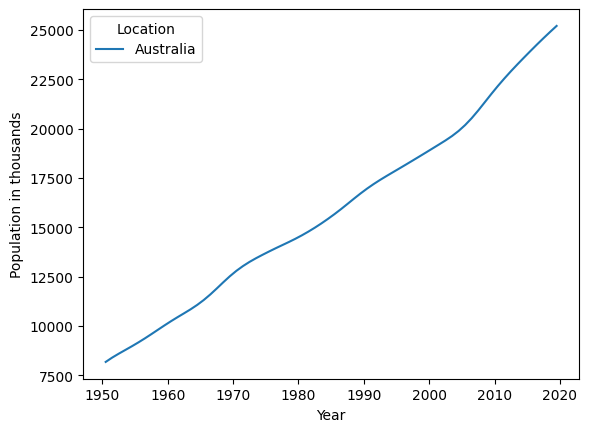

In [ ]:
ax = dataforplotting.pivot_table(index=['MidPeriod'], columns='Location', values='Population').plot()
ax.set_xlabel('Year');
ax.set_ylabel('Population in thousands');

**Bonus Exercise**: Plot the world population of children (age 0-17) along with those of the age groups 18-39 and 40+ from 1950 to 2019. You should display three lines (one for the population of each age group vs year) on the same plot. Note that 'World' is one of the locations.

Hint: one approach is to create a new column 'AgeCategory' based on AgeGrpStart using the 'when' function.

In [ ]:
# ANSWER


In [ ]:
agegrp_df = world_data.toPandas()

In [ ]:
ax = agegrp_df.pivot_table(index=['MidPeriod'], columns='AgeCategory', values='Population').plot()
ax.set_xlabel('Year');
ax.set_ylabel('Population in thousands');

## Population Pyramid

In this section we show how a population pyramid may be created. We look at China in the year 1980.

In [ ]:
china_1980 = df.filter((df.Location == 'China (and dependencies)') & (df.Time == 1980)).toPandas()

In [ ]:
china_1980

,LocID,Location,VarID,Variant,Time,MidPeriod,AgeGrp,AgeGrpStart,AgeGrpSpan,PopMale,PopFemale,PopTotal
0,1105,China (and dependencies),2,Medium,1980,1980.5,0,0,1,9345.832031,8896.928711,18242.761719
1,1105,China (and dependencies),2,Medium,1980,1980.5,1,1,1,10080.731445,9500.591797,19581.322266
2,1105,China (and dependencies),2,Medium,1980,1980.5,2,2,1,10769.024414,10093.152344,20862.175781
3,1105,China (and dependencies),2,Medium,1980,1980.5,3,3,1,11404.811523,10664.711914,22069.523438
4,1105,China (and dependencies),2,Medium,1980,1980.5,4,4,1,11982.184570,11205.377930,23187.562500
...,...,...,...,...,...,...,...,...,...,...,...,...
96,1105,China (and dependencies),2,Medium,1980,1980.5,96,96,1,1.198000,3.994000,5.192000
97,1105,China (and dependencies),2,Medium,1980,1980.5,97,97,1,0.894000,3.042000,3.936000
98,1105,China (and dependencies),2,Medium,1980,1980.5,98,98,1,0.576000,2.022000,2.598000
99,1105,China (and dependencies),2,Medium,1980,1980.5,99,99,1,0.240000,0.933000,1.173000


In [ ]:
china_1980.describe()

,Time,MidPeriod,AgeGrp,AgeGrpStart,AgeGrpSpan,PopMale,PopFemale,PopTotal
count,101.0,101.0,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,1980.0,1980.5,50.000000,50.000000,0.980198,5200.050293,4929.667969,10129.718750
std,0.0,0.0,29.300171,29.300171,0.199007,4547.521484,4259.914062,8804.997070
min,1980.0,1980.5,0.000000,0.000000,-1.000000,0.169000,0.933000,1.144000
25%,1980.0,1980.5,25.000000,25.000000,1.000000,843.093994,1183.671997,2026.765991
50%,1980.0,1980.5,50.000000,50.000000,1.000000,4447.303223,3898.085938,8345.388672
75%,1980.0,1980.5,75.000000,75.000000,1.000000,9345.832031,8896.928711,18242.761719
max,1980.0,1980.5,100.000000,100.000000,1.000000,14015.841797,13443.602539,27459.445312


Create age brackets in multiples of 5 - such as 0-4, 5-9, ...

In [ ]:
lower = china_1980['AgeGrpStart'] - (china_1980['AgeGrpStart'] % 5)

In [ ]:
agebrackets = [f'{x:02d}-{(x+4):02d}' for x in lower.values]
agebrackets[-1] = '100+'

In [ ]:
agebrackets[:10]

['00-04',
 '00-04',
 '00-04',
 '00-04',
 '00-04',
 '05-09',
 '05-09',
 '05-09',
 '05-09',
 '05-09']

In [ ]:
china_1980['AgeRange'] = agebrackets

Next find the populations by age range.

In [ ]:
agg_china_1980 = (china_1980.groupby(['AgeRange']).sum()[['PopMale', 'PopFemale']]/1000).reset_index()

<ipython-input-80-5eebe1db66f8>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  agg_china_1980 = (china_1980.groupby(['AgeRange']).sum()[['PopMale', 'PopFemale']]/1000).reset_index()


In [ ]:
rev_age = list(dict.fromkeys(agebrackets[::-1])) #reversed list of ages

In [ ]:
agg_china_1980['NegPopMale'] = -agg_china_1980['PopMale']

We are now ready to plot the population pyramid:

<ipython-input-83-d4fb341c2b66>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(labels)
<ipython-input-83-d4fb341c2b66>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_xticklabels(bar_plot.get_xticklabels(), size = 15);
<ipython-input-83-d4fb341c2b66>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  bar_plot.set_yticklabels(bar_plot.get_yticklabels(), size = 15);


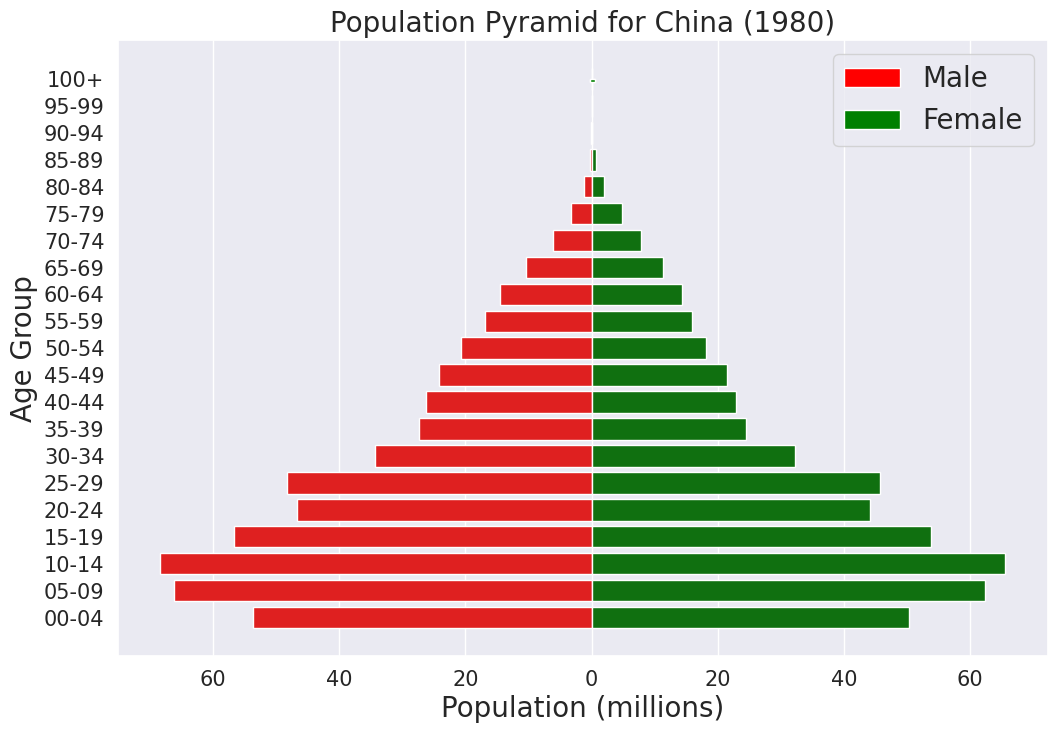

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
bar_plot = sns.barplot(x='NegPopMale', y='AgeRange', data=agg_china_1980, order = rev_age, color='red')
bar_plot = sns.barplot(x='PopFemale', y='AgeRange', data=agg_china_1980, order = rev_age, color='green')

labels = ["80", "60", "40", "20", "0", "20", "40", "60", "80"]
bar_plot.set_xticklabels(labels)

h = [bar_plot.bar(x=.1, height=.1, color = c) for c in ['red', 'green']] #used to set colour of bar in legend
bar_plot.legend(handles = h, labels=['Male', 'Female'], fontsize=20)

bar_plot.axes.set_title("Population Pyramid for China (1980)", fontsize=20);
bar_plot.set_xlabel("Population (millions)", fontsize=20);
bar_plot.set_ylabel("Age Group", fontsize=20);
bar_plot.set_xticklabels(bar_plot.get_xticklabels(), size = 15);
bar_plot.set_yticklabels(bar_plot.get_yticklabels(), size = 15);

## Prediction
Finally we use Spark's MLlib library in a linear regression problem. We shall predict the proportion of population to be of a particular age, given year.

Inputs:
- year
- age

Target variable:
- proportion of a country's population to be of that age, in that year


In [ ]:
pop_by_loc_and_year = df.groupBy('Location', 'Time')\
                        .sum('PopTotal')\
                        .withColumnRenamed('sum(PopTotal)', 'Location_year_pop')

In [ ]:
pop_by_loc_and_year.show()

+--------------------+----+------------------+
|            Location|Time| Location_year_pop|
+--------------------+----+------------------+
|       African Union|1999| 790628.6244071722|
|African Union: Ea...|1964| 78209.82484335266|
|             Albania|1960|1636.0909999981523|
|              Angola|1979| 8058.111999897286|
|              Angola|1987|10689.246978582349|
| Antigua and Barbuda|1995| 68.67199999373406|
| Antigua and Barbuda|2017|  95.4249999569729|
|           Argentina|2010| 40895.75102710724|
|          Azerbaijan|2012| 9264.683963924646|
|                BRIC|1981| 1991971.387032032|
|               BRICS|1994| 2523968.064731598|
|             Bahamas|1968|158.64800055802334|
|             Bahrain|2014|1336.0730002257042|
|          Bangladesh|1987| 95671.15840621479|
|            Barbados|2019| 287.0210008621216|
|Belt-Road Initiat...|1991| 579859.1757936478|
|Belt-Road Initiat...|1963| 497522.4002505541|
|Belt-Road Initiat...|2018| 1532885.483291626|
|Belt-Road In

In [ ]:
trainingset = df.join(pop_by_loc_and_year, ['Location', 'Time'])\
  .withColumn('Proportion',
              df.PopTotal/pop_by_loc_and_year.Location_year_pop)\
  .select('Time', 'AgeGrpStart', 'Proportion')

**Exercise**: Use the stat.corr function to find the correlation between AgeGrpStart and Proportion.

In [ ]:
# ANSWER
trainingset.stat.corr('AgeGrpStart' , 'Proportion')


-0.9037593727579873

Next we create a simple linear regression model predict Ratio from Time and AgeGrpStart.

In [ ]:
from pyspark.ml.regression import LinearRegression

MLlib takes input in vector form. Hence we need to create vectors from features.

In [ ]:
from pyspark.ml.feature import VectorAssembler
featureassembler=VectorAssembler(inputCols=['Time', 'AgeGrpStart'],
                                 outputCol='Features')

In [ ]:
final_data_for_regression = featureassembler.transform(trainingset).select('Features', 'Proportion')
final_data_for_regression.show()

+-------------+--------------------+
|     Features|          Proportion|
+-------------+--------------------+
| [1999.0,0.0]|0.034861880698940154|
| [1999.0,1.0]|0.033504117654464094|
| [1999.0,2.0]| 0.03229754709870501|
| [1999.0,3.0]|0.031226978883906742|
| [1999.0,4.0]| 0.03036231881608717|
| [1999.0,5.0]|0.029540022684496337|
| [1999.0,6.0]| 0.02879784229235586|
| [1999.0,7.0]|0.028121706557925764|
| [1999.0,8.0]| 0.02749754439946607|
| [1999.0,9.0]|0.026922376581622418|
|[1999.0,10.0]|0.026393226339384863|
|[1999.0,11.0]| 0.02584056829977413|
|[1999.0,12.0]|0.025228194624822717|
|[1999.0,13.0]|0.024575277657470227|
|[1999.0,14.0]| 0.02394366246993583|
|[1999.0,15.0]|0.023328689992668676|
|[1999.0,16.0]|0.022669283430560058|
|[1999.0,17.0]|0.021943661756977005|
|[1999.0,18.0]| 0.02117703730693325|
|[1999.0,19.0]|0.020418749034089554|
+-------------+--------------------+
only showing top 20 rows



In [ ]:
train, test = final_data_for_regression.randomSplit([0.9,0.1])

In [ ]:
train

DataFrame[Features: vector, Proportion: double]

Next we cache these dataframes into memory:

In [ ]:
train = train.cache()

In [ ]:
test = test.cache()

We are ready to train the model. This may take a minute or so due to the size of training set.

In [ ]:
regressor = LinearRegression(featuresCol='Features', labelCol='Proportion')
regressor = regressor.fit(train)

In [ ]:
regressor.coefficients

DenseVector([-0.0, -0.0003])

In [ ]:
regressor.intercept

0.02280457471568164

In [ ]:
predicted_results = regressor.evaluate(test)

Here we can compare some predicted proportions with actual proportions:

In [ ]:
predicted_results.predictions.show()

+------------+--------------------+--------------------+
|    Features|          Proportion|          prediction|
+------------+--------------------+--------------------+
|[1950.0,0.0]|0.031261955267252985|0.022758714436476712|
|[1950.0,0.0]|0.032749185658808216|0.022758714436476712|
|[1950.0,0.0]|  0.0327610717705694|0.022758714436476712|
|[1950.0,0.0]| 0.03279190572551684|0.022758714436476712|
|[1950.0,0.0]| 0.03315980958325287|0.022758714436476712|
|[1950.0,0.0]| 0.03446022101390343|0.022758714436476712|
|[1950.0,0.0]|0.035289197666370675|0.022758714436476712|
|[1950.0,0.0]| 0.03859816014221689|0.022758714436476712|
|[1950.0,0.0]| 0.03884664278805715|0.022758714436476712|
|[1950.0,1.0]| 0.01732395228191049|0.022499808233667516|
|[1950.0,1.0]| 0.02055889166419327|0.022499808233667516|
|[1950.0,1.0]|0.029604554386521455|0.022499808233667516|
|[1950.0,1.0]|0.030999564378914806|0.022499808233667516|
|[1950.0,1.0]|0.031026403708459323|0.022499808233667516|
|[1950.0,1.0]|0.034570200421613

**Exercise**: Find R-squared and the mean squared error using the 'r2' and 'meanSquaredError' attributes.

In [ ]:
# ANSWER
predicted_results.meanSquaredError,predicted_results.r2

(1.2740930971083962e-05, 0.8174679813832463)

## Conclusion

We have seen how to use Pyspark to make queries on a large dataset, save smaller datasets into Pandas dataframe for plotting and how to use MLlib for machine learning on a large dataset.



---



---



> > > > > > > > > © 2023 Institute of Data


---



---



